# Setup

In [1]:
!pip install -q tf-models-official==2.3.0
!pip install transformers

     |████████████████████████████████| 849kB 6.9MB/s 
     |████████████████████████████████| 1.2MB 22.6MB/s 
     |████████████████████████████████| 174kB 36.8MB/s 
     |████████████████████████████████| 37.6MB 83kB/s 
     |████████████████████████████████| 358kB 55.7MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 1.8MB 6.9MB/s 
     |████████████████████████████████| 890kB 54.1MB/s 
     |████████████████████████████████| 2.9MB 51.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=bdcbe7622a33b979e774123ed188af40fd4c571ee6c9fa1325160a7697d7109b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import os
import json, pickle

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras import Model
from keras.utils import plot_model
from keras.layers import Input, Dense, Flatten, Concatenate
from transformers import TFBertModel

This directory contains the configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

In [3]:
# import sys
# !git clone "https://github.com/giuliofortini/NLP_SQuAD_Project"
# sys.path.append("NLP_SQuAD_Project/")

from google.colab import files
try:
  with open('training_set.json') as f:
    json_data = json.load(f)
except:
  from google.colab import drive
  drive.mount('/content/drive')
  with open('/content/drive/My Drive/SQUAD/training_set.json') as f:
    json_data = json.load(f)

Mounted at /content/drive


# Hyperparameters


In [4]:
# hyperparams
SEQUENCE_LIMIT = 512
STRIDE = 256

# <s> Dataset </s>

In [ ]:
data = pd.json_normalize(json_data['data'])
data

,title,paragraphs
0,University_of_Notre_Dame,"[{'context': 'Architecturally, the school has ..."
1,Beyoncé,[{'context': 'Beyoncé Giselle Knowles-Carter (...
2,Montana,[{'context': 'Montana i/mɒnˈtænə/ is a state i...
3,Genocide,"[{'context': 'The phrase ""in whole or in part""..."
4,Antibiotics,[{'context': 'The emergence of resistance of b...
...,...,...
437,Police,[{'context': 'A police force is a constituted ...
438,"Punjab,_Pakistan","[{'context': 'Punjab (Urdu, Punjabi: پنجاب, pa..."
439,Infection,[{'context': ' Among the vast varieties of mic...
440,Hunting,[{'context': 'Hunting is the practice of killi...


In [ ]:
train, test = train_test_split(data, test_size=0.2)

In [ ]:
def preprocess_df(df):
  temp = []
  title_dict = {}
  contexts = []

  for i, row in df.iterrows():
    for context in row['paragraphs']:
      contexts.append(context['context'])
      for qa in context['qas']:
        question_id = qa['id']
        question = qa['question']
        for answer in qa['answers']:
          answer_text = answer['text']
          answer_start = answer['answer_start']
          answer_end = answer_start+len(answer_text)
          temp.append([question_id, question, answer_text, answer_start, answer_end, i, len(contexts)-1])


  context_dict = dict(enumerate(contexts))

  df = pd.DataFrame(temp, columns=['question_id', 'question_text', 'answer_text', 'answer_start', 'answer_end', 'title_id', 'context_id'])
  
  return df, context_dict

train_df, train_context_dict = preprocess_df(train)
test_df, test_context_dict = preprocess_df(test)

In [ ]:
train_df

,question_id,question_text,answer_text,answer_start,answer_end,title_id,context_id
0,572ed956c246551400ce471c,What is the use of a transistor?,to amplify or switch electronic signals and el...,44,104,379,0
1,572ed956c246551400ce471d,What is a transistor made of?,semiconductor material,124,146,379,0
2,572ed956c246551400ce471f,Why does a transistor increase a signal?,the controlled (output) power can be higher th...,350,428,379,0
3,572ed956c246551400ce471e,What is the minimum amount of external connect...,three,161,166,379,0
4,572ed956c246551400ce4720,Where are most transistors found?,embedded in integrated circuits,540,571,379,0
...,...,...,...,...,...,...,...
70726,572616c289a1e219009ac236,At what stadium do Arsenal Ladies usually play?,Boreham Wood.,733,746,192,15230
70727,572616c289a1e219009ac235,By 2009 what competition has Arsenal Ladies be...,UEFA Women's Cup,439,455,192,15230
70728,572616c289a1e219009ac233,When did the Arsenal Ladies team become semi-p...,2002,118,122,192,15230
70729,572616c289a1e219009ac234,How does Arsenal Ladies rank as compared with ...,most successful,181,196,192,15230


In [ ]:
import random
def print_squad_sample(train_data, context_dict, line_length=120, separator_length=150):
  sample = train_data.sample(frac=1).head(1)
  context = context_dict[sample['context_id'].item()]
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [''.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
  for l in lines:
      print(l)
  #print(context)
  print('='*separator_length)
  questions = train_data[train_data['context_id'] == sample['context_id'].item()]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), answer)

print_squad_sample(train_df, train_context_dict)

CONTEXT: 
During this period, Bengal witnessed an intellectual awakening that is in some way similar to the Renaissance in Europe 
during the 16th century, although Europeans of that age were not confronted with the challenge and influence of alien co
lonialism. This movement questioned existing orthodoxies, particularly with respect to women, marriage, the dowry system
, the caste system, and religion. One of the earliest social movements that emerged during this time was the Young Benga
l movement, which espoused rationalism and atheism as the common denominators of civil conduct among upper caste educate
d Hindus. It played an important role in reawakening Indian minds and intellect across the sub-continent.
QUESTION:                                                                                                                  ANSWER:
What did the Bengali Renaissance resemble?                                                                                 Renaissance in Europe
Wha

# <s> Tokenizer </s>

In [ ]:
from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print('[[CLS], [SEP]] = {}'.format(tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])))

[[CLS], [SEP]] = [101, 102]


In [ ]:
# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(train_df['question_text'][0])

# Print out the tokens.
print(tokenized_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6}'.format(tup[0], tup[1]))

['what', 'is', 'the', 'use', 'of', 'a', 'trans', '##isto', '##r', '?']
what           2054
is             2003
the            1996
use            2224
of             1997
a              1037
trans          9099
##isto        20483
##r            2099
?              1029


In [ ]:
a = tf.convert_to_tensor(np.array(list(range(100))))
b = list(range(32, 50))

def find_sublist(a, b):
  if len(a) == 0 or len(b) == 0:
    raise Exception("AAAAAAA")

  found = False
  for i in range(len(a) - len(b) +1):
    if np.array_equal(a[i:i+len(b)], b):
      return i, i+len(b)-1

  return -1, -1

find_sublist(a, b)

(32, 49)

In [ ]:
def print_progress(value, total, bar_width=100):
  perc = int(value/total*bar_width)
  rest = bar_width - perc
  print("\r{:>3} % [ {}{} ]".format(perc, perc*'■', rest*'─'), end="")

# ensure to preserve all sub-sequences of length limi-stride. 
def split_long_sequence(my_sequence, limit, stride):

  if len(my_sequence) <= limit: 
    return [my_sequence]
  
  rest = my_sequence
  split = []
  while len(rest) > limit:
    left_hand = rest[:limit]
    rest = rest[stride:]
    split.append(left_hand)
    
  split.append(rest)
  return split 

In [ ]:
def from_df_to_model_dict(df, context_dict, verbose=False):

  # initialize structures
  input_ids = []
  input_mask = []
  input_type_ids = []
  start_indexes = []
  end_indexes = []

  cut_counter = 0
  max_iter = len(df)
  new_entries = 0
  for i, row in df.iterrows():

    # print progress
    if (i+1) % (max_iter // 100) == 0 or i == 0:
      # perc = int(i/max_iter*100)+1
      # rest = 100 - perc
      # print(f"\r{perc} % [ {perc*'■'}{rest*'─'} ]", end="")
      print_progress(i+1, max_iter)

    # encode question and context
    if verbose: print("\tTokenizing question and context...", end="")
    encoded_question = tokenizer.encode(row['question_text'])
    encoded_context = tokenizer.encode(context_dict[row['context_id']])[1:]

    # concatenate input data 
    #encoded_input = encoded_question + encoded_context
    if verbose: print("\tChecking sequence length...")
    if len(encoded_question + encoded_context) > SEQUENCE_LIMIT:
      # if the sequence is too long, split it in n subsequences of length <= SEQUENCE_LIMIT
      encoded_contexts = split_long_sequence(encoded_context,
                                             limit=SEQUENCE_LIMIT-len(encoded_question), 
                                             stride=STRIDE)

      cut_counter += 1
    else:
      encoded_contexts = [encoded_context]
    
    new_entries += len(encoded_contexts)-1
    # for each too long sequence, the context has been split in n parts. We need to process them separately, creating new entries for the input
    for context in encoded_contexts:
      
      encoded_input = encoded_question + context      

      # create mask of ones
      ones_mask = tf.ones_like(encoded_input)

      # add padding and convert to tensor
      if verbose: print("\tPadding...", end="")
      encoded_input = tf.keras.preprocessing.sequence.pad_sequences([encoded_input], maxlen=512, padding='pre')
      encoded_input = tf.squeeze(tf.convert_to_tensor(encoded_input))
      # processing answer indices
      #print("\tProcessing answer...")
      tokenized_answer = tokenizer.encode(row['answer_text'])[1: -1]
      # try:
      #   start_idx = encoded_input[tokenized_answer][0]
      #   end_idx = start_idx + len(tokenized_answer)
      # except ValueError:
      #   start_idx = -1
      #   end_idx = -1
      start_idx, end_idx = find_sublist(encoded_input, tokenized_answer)
      # print(encoded_input)
      # print(tokenized_answer)
      # print((start_idx, end_idx))
      start_indexes.append(start_idx)
      end_indexes.append(end_idx)


      # create input_type_ids
      if verbose: print("\tInput types creation...", end="")
      type_ids = tf.concat([tf.zeros_like(encoded_question, dtype=tf.int32), 
                            tf.ones_like(encoded_context, dtype=tf.int32)], 
                          axis=-1)

      type_ids = tf.keras.preprocessing.sequence.pad_sequences([type_ids], maxlen=512, padding='pre')
      type_ids = tf.squeeze(tf.convert_to_tensor(type_ids))


      # create mask of zeros
      if verbose: print("\tMask creation...", end="")
      # zeros_mask = tf.zeros_like(tf.shape(encoded_question)[-1]-tf.shape(ones_mask)[-1], dtype=tf.int32)
      zeros_mask = tf.zeros(SEQUENCE_LIMIT - len(ones_mask), dtype=tf.int32)
      mask = tf.concat([zeros_mask, ones_mask], axis=-1)

      # append elements to lists
      if verbose: print("\tAppending inputs...", end="")
      input_ids.append(encoded_input)
      input_mask.append(mask)
      input_type_ids.append(type_ids)

  # save input data as dictionary
  inputs = {
    'input_ids': tf.convert_to_tensor(input_ids),
    'attention_mask': tf.convert_to_tensor(input_mask),
    'token_type_ids': tf.convert_to_tensor(input_type_ids)
    }

  assert len(input_ids) == len(df) + new_entries, f"DIOCANE:\nci sono {len(input_ids)} input_ids, MA {len(df)} righe nel df e {new_entries} nuove entries 8===D"
  return inputs, start_indexes, end_indexes

In [ ]:
print("Building training set...")
train_inputs, train_starts, train_ends = from_df_to_model_dict(train_df, train_context_dict)

print("\n\nBuilding test set...")
test_inputs, test_starts, test_ends = from_df_to_model_dict(test_df, test_context_dict)


Building training set...
  7 % [ ■■■■■■■───────────────────────────────────────────────────────────────────────────────────────────── ]

Token indices sequence length is longer than the specified maximum sequence length for this model (695 > 512). Running this sequence through the model will result in indexing errors


 99 % [ ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■─ ]

Building test set...
 99 % [ ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■─ ]

## Save train and test inputs dataset

In [ ]:
# ## TRAIN
# with open("/content/drive/MyDrive/SQUAD/train_inputs.p", "wb") as f:
#   pickle.dump(train_inputs, f)

# with open("/content/drive/MyDrive/SQUAD/train_starts.p", "wb") as f:
#   pickle.dump(train_starts, f)

# with open("/content/drive/MyDrive/SQUAD/train_ends.p", "wb") as f:
#   pickle.dump(train_ends, f)


# ## TEST
# with open("/content/drive/MyDrive/SQUAD/test_inputs.p", "wb") as f:
#   pickle.dump(test_inputs, f)

# with open("/content/drive/MyDrive/SQUAD/test_starts.p", "wb") as f:
#   pickle.dump(test_starts, f)

# with open("/content/drive/MyDrive/SQUAD/test_ends.p", "wb") as f:
#   pickle.dump(test_ends, f)


200

# Load train and test inputs datasets

In [ ]:
## TRAIN
with open("/content/drive/MyDrive/SQUAD/train_inputs.p", "rb") as f:
  train_inputs = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/y_train_starts.p", "rb") as f:
  y_train_starts = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/y_train_ends.p", "rb") as f:
  y_train_ends = pickle.load(f)


## TEST
with open("/content/drive/MyDrive/SQUAD/test_inputs.p", "rb") as f:
  test_inputs = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/y_test_starts.p", "rb") as f:
  y_test_starts = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/y_test_ends.p", "rb") as f:
  y_test_ends = pickle.load(f)


In [ ]:
# make data categorical
y_train_starts = tf.keras.utils.to_categorical([val if val != -1 else 0 for val in train_starts], num_classes=SEQUENCE_LIMIT)
y_train_ends = tf.keras.utils.to_categorical([val if val != -1 else 0 for val in train_ends], num_classes=SEQUENCE_LIMIT)

y_test_starts = tf.keras.utils.to_categorical([val if val != -1 else 0 for val in test_starts], num_classes=SEQUENCE_LIMIT)
y_test_ends = tf.keras.utils.to_categorical([val if val != -1 else 0 for val in test_ends], num_classes=SEQUENCE_LIMIT)

# Build model

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config o

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_4[0][0]                    
                                                                 input_5[0][0]              

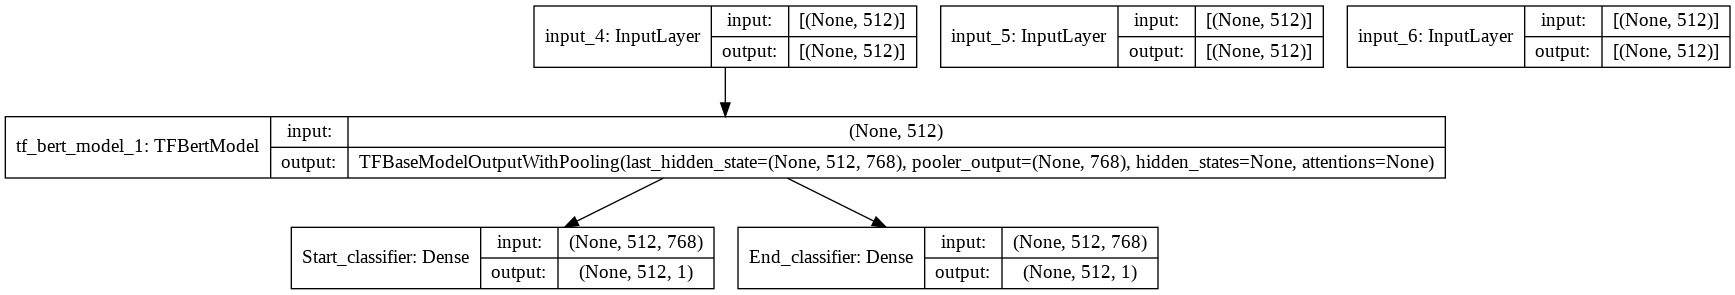

In [ ]:
@tf.autograph.experimental.do_not_convert
def build_model():
  output_dim = SEQUENCE_LIMIT # add one class for non-found answers

  input_ids_layer = Input(shape = (512,), dtype='int64')
  attention_mask_layer = Input(shape = (512,), dtype='int64')
  token_ids_layer = Input(shape = (512,), dtype='int64')

  bert_model = TFBertModel.from_pretrained('bert-base-uncased')
  
  for layer in bert_model.layers:
    layer.trainable = False
  
  bert = bert_model(input_ids = input_ids_layer,
                    attention_mask = attention_mask_layer,
                    token_type_ids = token_ids_layer,
                    return_dict = False,
                    output_attentions = False,
                    output_hidden_states = False
                    ).last_hidden_state
  
  flat = Flatten()(bert)
  start_classifier = Dense(units=1, activation="softmax", name="Start_classifier")(bert)
  end_classifier = Dense(units=1, activation="softmax", name="End_classifier")(bert)

  model = Model(inputs=[input_ids_layer, attention_mask_layer, token_ids_layer], 
                outputs=[start_classifier, end_classifier])
  model.summary()
  return model


model = build_model()
plot_model(model, show_shapes=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train

In [ ]:
EPOCHS = 3

In [ ]:
assert y_test_ends.shape[1] == 512

In [ ]:
model_fit = model.fit(x = [train_inputs['input_ids'],
                           train_inputs['attention_mask'],
                           train_inputs['token_type_ids']],
                      y = [y_train_starts, y_train_ends],
                       
                      batch_size=32, epochs=EPOCHS, 
                      validation_data=([test_inputs['input_ids'],
                                        test_inputs['attention_mask'],
                                        test_inputs['token_type_ids']], 
                                       [y_test_starts,
                                         y_test_ends]
                                       )
)
                  

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2214/2214 [==============================] - ETA: 0s - loss: 12.4766 - Start_classifier_loss: 6.2383 - End_classifier_loss: 6.2383 - Start_classifier_accuracy: 0.0025 - End_classifier_accuracy: 0.0025

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2214/2214 [==============================] - 4144s 2s/step - loss: 12.4766 - Start_classifier_loss: 6.2383 - End_classifier_loss: 6.2383 - Start_classifier_accuracy: 0.0025 - End_classifier_accuracy: 0.0025 - val_loss: 12.4766 - val_Start_classifier_loss: 6.2383 - val_End_classifier_loss: 6.2383 - val_Start_classifier_accuracy: 0.0030 - val_End_classifier_accuracy: 0.0030
Epoch 2/3
 370/2214 [====>.........................] - ETA: 47:38 - loss: 12.4766 - Start_classifier_loss: 6.2383 - End_classifier_loss: 6.2383 - Start_classifier_accuracy: 0.0037 - End_classifier_accuracy: 0.0037

In [ ]:
TEST_LIMIT = len(test_inputs)

start_pred, end_pred = model.predict([test_inputs["input_ids"][:TEST_LIMIT], 
                                      test_inputs["attention_mask"][:TEST_LIMIT], 
                                      test_inputs["token_type_ids"][:TEST_LIMIT]])
start_pred = np.argmax(start_pred, axis=1)
end_pred = np.argmax(end_pred, axis=1)


def get_text_from_token_ids(context, start_id, end_id):
  return tokenizer.decode(context[start_id:end_id])



boom_baby = 0
for i, row in test_df.iterrows():
  if i == TEST_LIMIT: break
  true_answer = row["answer_text"]
  predicted_answer = get_text_from_token_ids(test_inputs["input_ids"][i-1], start_pred[i-1], end_pred[i-1])

  if true_answer == predicted_answer:
    boom_baby += 1

  if i % 1000 == 0:
    print("\n\nQuestion: \n", row["question_text"])
    print("Context: \n", test_context_dict[row["context_id"]])
    print("Answer text: \n", true_answer)
    print(f"Our answer: \n\tids {(start_pred[i-1], end_pred[i-1])}\n\ttext: {predicted_answer}")
    print("-"*50)

In [ ]:
print(f"Total matches\t{boom_baby} / {TEST_LIMIT} \t({round(boom_baby / TEST_LIMIT, 3)*100} %)")

In [ ]:
with open("results_2101_start_pred.txt", "w") as f:
  f.write(start_pred)

with open("results_2101_end_pred.txt", "w") as f:
  f.write(end_pred)